In [284]:
pip install keras.preprocessing.sequence 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.preprocessing.sequence (from versions: none)
ERROR: No matching distribution found for keras.preprocessing.sequence


In [285]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [286]:
data = pd.read_csv('/content/complaints.csv', engine='python', encoding='utf-8', on_bad_lines="skip", sep=',')


In [287]:
data.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-10-27,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",FL,33169,NaN,NaN,Web,2022-10-27,In progress,Yes,NaN,6138046.0
1,2022-10-22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,TX,76180,NaN,NaN,Web,2022-10-22,In progress,Yes,NaN,6117096.0
2,2022-10-15,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"Frontline Asset Strategies, LLC",TX,77379,NaN,NaN,Web,2022-10-15,Closed with explanation,Yes,NaN,6089209.0
3,2022-10-21,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NY,11738,NaN,Consent not provided,Web,2022-10-21,Closed with non-monetary relief,Yes,NaN,6114465.0
4,2022-10-13,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Card was charged for something you did not pur...,my original credit card with universal card ac...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",GA,30620,"Older American, Servicemember",Consent provided,Web,2022-10-13,Closed with monetary relief,Yes,NaN,6084329.0


In [288]:
data = data[["Product","Consumer complaint narrative"]]


In [289]:
data.head()


,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,"Credit reporting, credit repair services, or o...",NaN
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,Credit card or prepaid card,my original credit card with universal card ac...


In [290]:
data.isna().sum()


Product                              0
Consumer complaint narrative    198730
dtype: int64

In [291]:
data.dropna(subset=['Consumer complaint narrative'], inplace=True)
print(len(data))
print(data.isna().sum())

99364
Product                         0
Consumer complaint narrative    0
dtype: int64


In [292]:
data.Product.value_counts()


Credit reporting, credit repair services, or other personal consumer reports    65256
Debt collection                                                                 10086
Credit card or prepaid card                                                      6364
Checking or savings account                                                      5317
Mortgage                                                                         4725
Money transfer, virtual currency, or money service                               2292
Student loan                                                                     1393
Vehicle loan or lease                                                            1319
Payday loan, title loan, or personal loan                                         892
Credit reporting                                                                  597
Credit card                                                                       420
Bank account or service                               

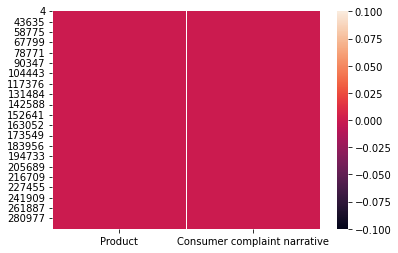

In [293]:
sns.heatmap(data.isnull())


In [294]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'


In [295]:
data.Product.value_counts()


Credit reporting, credit repair services, or other personal consumer reports    65853
Debt collection                                                                 10086
Credit card or prepaid card                                                      6784
Checking or savings account                                                      5317
Mortgage                                                                         4725
Money transfer, virtual currency, or money service                               2292
Student loan                                                                     1393
Vehicle loan or lease                                                            1319
Payday loan, title loan, or personal loan                                         935
Bank account or service                                                           355
Consumer Loan                                                                     240
Prepaid card                                          

In [296]:

data.loc[data['Product'] == 'Prepaid card'] = 'Other financial service'
data.loc[data['Product'] == 'Consumer Loan'] = 'Other financial service'
data.loc[data['Product'] == 'Bank account or service']  = 'Other financial service'

In [297]:
data.Product.value_counts()


Credit reporting, credit repair services, or other personal consumer reports    65853
Debt collection                                                                 10086
Credit card or prepaid card                                                      6784
Checking or savings account                                                      5317
Mortgage                                                                         4725
Money transfer, virtual currency, or money service                               2292
Student loan                                                                     1393
Vehicle loan or lease                                                            1319
Payday loan, title loan, or personal loan                                         935
Other financial service                                                           632
Money transfers                                                                    28
Name: Product, dtype: int64

In [298]:
data = data.reset_index(drop=True)


In [299]:
len(data.Product.value_counts())


11

In [300]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [301]:
complaint_product(238, data)


I have a Sam 's Club Account with Syncronicity Bank and they just arbitrarily closed my account without warning. I was also denied credit by them but they kept another account open with Care Credit and increased my limit. I always paid ontime using auto pay and paid more than my minimum payment. This has effected my credit score and my credit worthiness. This is a violation of my rights according to 15 U.S. Code 1681.
------------------------------
Product :  Credit card or prepaid card


In [302]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [303]:
data.head()


,Product,Consumer complaint narrative
0,Credit card or prepaid card,my original credit card with universal card ac...
1,"Credit reporting, credit repair services, or o...","Hello, In XXXX, my Macy 's credit card was clo..."
2,Vehicle loan or lease,On XX/XX/XXXX I was taken out of work due to a...
3,Debt collection,Hey all items been paid and full but still sho...
4,Mortgage,As the executor of my mother 's estate I sold ...


In [304]:
data['Consumer complaint narrative'] = data.apply(lambda row: clean_text(row['Consumer complaint narrative']), axis=1)


In [305]:
complaint_product(228, data)


ic system reporting debt credit report eplained debt told paid would delete paid still reporting credit report paying agreed delete paying
------------------------------
Product :  Debt collection


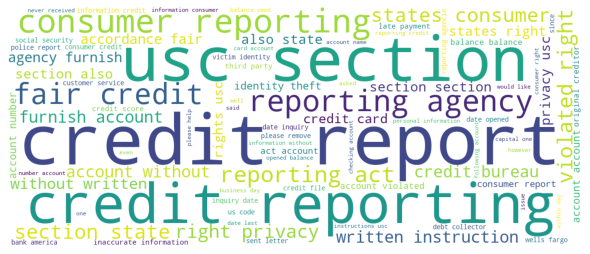

In [306]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [307]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]


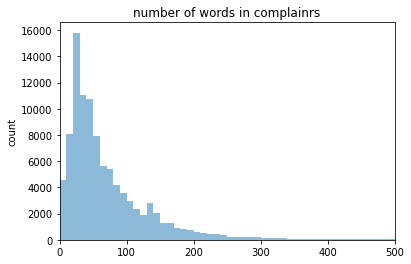

In [308]:
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

In [309]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 50865 unique tokens.


In [310]:
from keras_preprocessing.sequence import pad_sequences



In [311]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (99364, 250)


In [312]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (99364, 11)


In [313]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 123)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(69554, 250) (69554, 11)
(29810, 250) (29810, 11)


In [314]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_12 (Spati  (None, 250, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dense_19 (Dense)            (None, 10)                1010      
                                                                 
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [315]:
model = Sequential()
model.add(Embedding( 50000, 100, input_length=X_train.shape[-1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_13 (Spati  (None, 250, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_20 (LSTM)              (None, 100)               80400     
                                                                 
 dense_20 (Dense)            (None, 10)                1010      
                                                                 
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [316]:
from keras.models import Sequential


In [317]:
import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers
batch_size = 64
input_dim = 28
units = 64
output_size = 10

def build_model(allow_cudnn_kernel=True):
  if allow_cudnn_kernel:
    lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
  else:
    lstm_layer = tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(units),
        input_shape=(None, input_dim))
  model = tf.keras.models.Sequential([
      lstm_layer,
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size, activation='softmax')]
  )
  return model

In [318]:

model.compile(
   loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'],
)




In [319]:


history=model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=64,
          epochs=5)

Epoch 1/5


ValueError: ignored

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))


In [ ]:
score = None
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))


In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [ ]:
expected_classes = np.argmax(Y_test, axis=1)